# Mehmet Uzel

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

import pandas as pd
import numpy as np
import math
import re

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn import preprocessing
from sklearn import metrics

In [3]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1

In [4]:
def fix_missing(df, col, name, nan_dict, is_train):
    
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_na"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])
            
            
    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_na"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])
                
        
            else:
                df[name] = col.fillna(col.median())
            
            

In [5]:
def proc_df(df, y_fld,nan_dict=None,is_train=True):
    
    df = df.copy()
    y = df[y_fld].values
    
    df.drop(y_fld, axis = 1, inplace = True)
    
    if nan_dict is None:
        nan_dict = {}
    
    for n, c in df.items():
        fix_missing(df, c, n,nan_dict, is_train)
        numericalize(df, c, n)
        
        
    
    return df, y, nan_dict

In [6]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

In [9]:
train_n=train[[c for c in train.columns if train[c].dtypes!='O']].copy()
test_n=test[[c for c in test.columns if test[c].dtypes!='O']].copy()

train_c=train[[c for c in train.columns if train[c].dtypes=='O']].copy()
test_c=test[[c for c in test.columns if test[c].dtypes=='O']].copy()

In [10]:
corrmat=train_n.corr()


In [11]:
n=15
top15_cols=corrmat.nlargest(n,'SalePrice')['SalePrice'].index

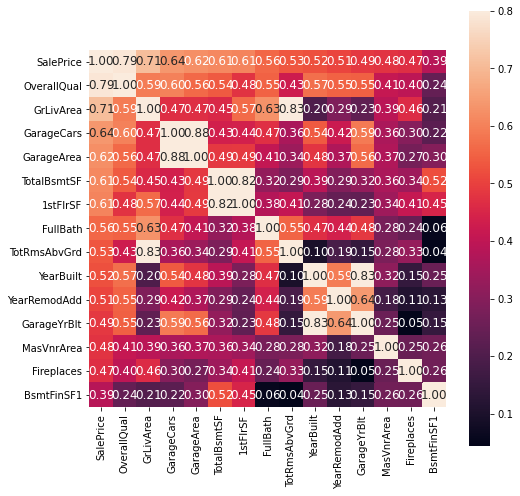

In [12]:
corrmat_top15=train_n[top15_cols].corr()
fig1,ax1=plt.subplots(figsize=(8,8))
sns.heatmap(corrmat_top15,vmax=.8, square=True,ax=ax1,annot=True, fmt='.2f', annot_kws={'size': 12})

In [13]:
train_n1=train_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)
test_n1=test_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)

In [14]:
non_linear=['MSSubClass','LotArea','OverallCond','LowQualFinSF','BsmtFullBath', 'BsmtHalfBath','FullBath', 'HalfBath','BedroomAbvGr',
            'KitchenAbvGr','Fireplaces','3SsnPorch','ScreenPorch' ,'PoolArea','MiscVal','MoSold', 'YrSold']
print("total non-linear",len(non_linear)," columns")

total non-linear 17  columns


In [15]:
linear_features=np.array([col for col in train_n1.columns if col not in non_linear])


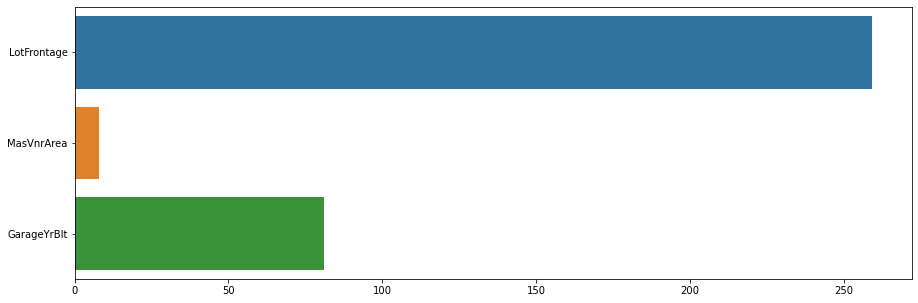

In [16]:
fig=plt.figure(figsize=(15,5))
train_null=train_n1.isnull().sum()[train_n1.isnull().sum()!=0]
sns.barplot(y=train_null.index,x=train_null)

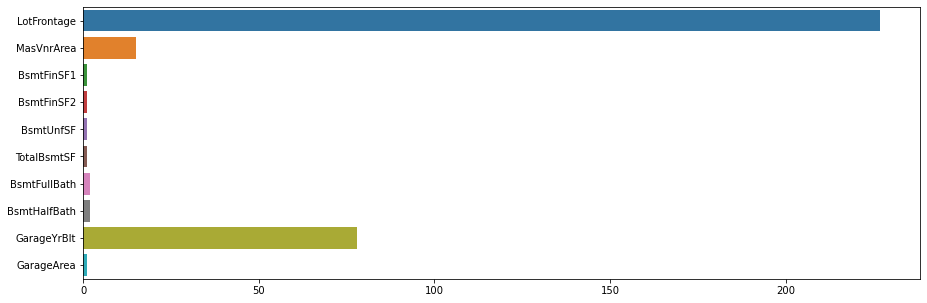

In [17]:
fig=plt.figure(figsize=(15,5))
test_null=test_n1.isnull().sum()[test_n1.isnull().sum()!=0]
sns.barplot(y=test_null.index,x=test_null)

In [18]:
train_n1['GarageYrBlt']=train_n1['GarageYrBlt'].fillna(train_n1['GarageYrBlt'].median())
test_n1['GarageYrBlt']=test_n1['GarageYrBlt'].fillna(test_n1['GarageYrBlt'].median())

for col in train_n1.columns:
    train_n1[col] = train_n1[col].fillna(0)
for col in test_n1.columns:
    test_n1[col] = test_n1[col].fillna(0)

In [19]:
print(train_n1[linear_features].shape)
print(test_n1[linear_features[:-1]].shape)

(1460, 17)
(1459, 16)


In [20]:
train_n1.isnull().sum()[train_n1.isnull().sum()!=0]

Series([], dtype: int64)

In [21]:
test_n1.isnull().sum()[test_n1.isnull().sum()!=0]


Series([], dtype: int64)

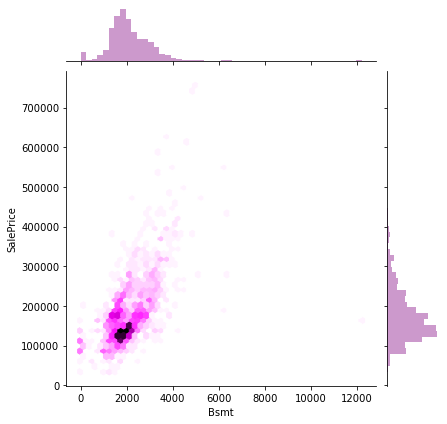

In [22]:
train_n1['Bsmt']=train_n1['BsmtFinSF1']+train_n1['BsmtFinSF2']+train_n1['BsmtUnfSF']+train_n1['TotalBsmtSF']
test_n1['Bsmt']=test_n1['BsmtFinSF1']+test_n1['BsmtFinSF2']+test_n1['BsmtUnfSF']+test_n1['TotalBsmtSF']
sns.jointplot(train_n1['Bsmt'],train_n1['SalePrice'],kind='hex',color='purple')

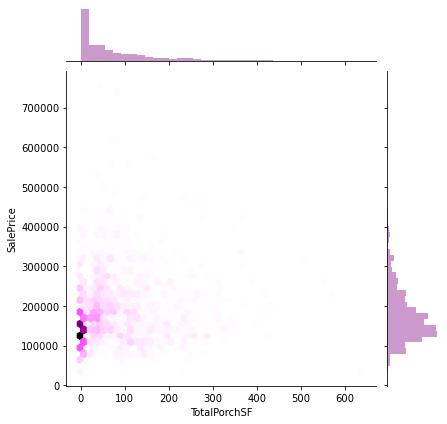

In [23]:
train_n1['TotalPorchSF']=train_n1['EnclosedPorch']+train_n1['OpenPorchSF']
test_n1['TotalPorchSF']=test_n1['EnclosedPorch']+test_n1['OpenPorchSF']

sns.jointplot(train_n1['TotalPorchSF'],train_n1['SalePrice'],kind='hex',color='purple')

In [24]:
linear_features

array(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'SalePrice'], dtype='<U13')

In [25]:
linear_features=['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea','Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

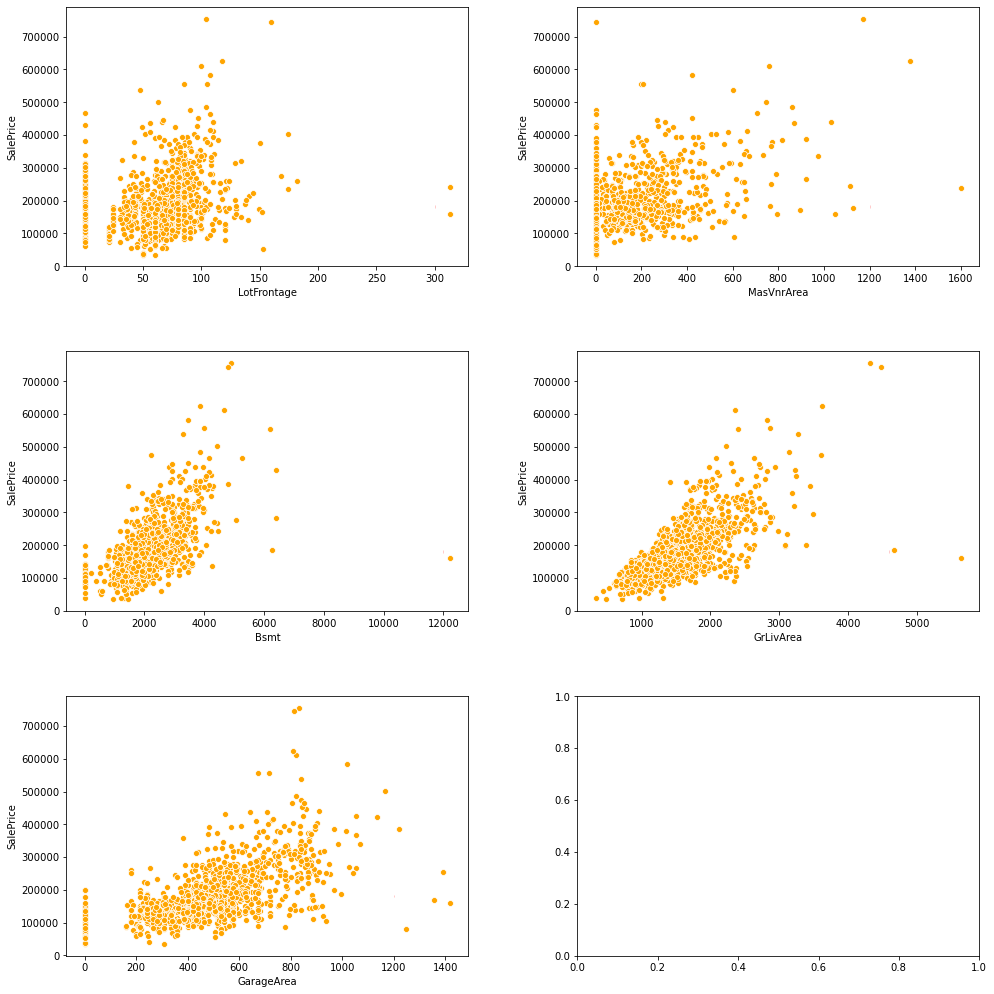

In [26]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
def graph(x,y,r,c,title,line):
    sns.scatterplot(train_n1[x],train_n1[y],color=('orange'),ax=ax[r][c])
    sns.lineplot(x=line,y=train_n1[y],color='red',ax=ax[r][c])
    ax[r][c].set_ylabel(y)
    ax[r][c].set_xlabel(x)
    fig.tight_layout(pad=5.0)

out=[300,1200,12000,4600,1200]
for r,col in enumerate(np.array(['LotFrontage','MasVnrArea','Bsmt','GrLivArea','GarageArea'])):
    c=r%2
    graph(col,'SalePrice',r//2,c,col,out[r])

In [27]:
a=train_n1['LotFrontage'].sort_values(ascending=False).head(2)
b=train_n1['MasVnrArea'].sort_values(ascending=False).head(2)
c=train_n1['Bsmt'].sort_values(ascending=False).head(1)
d=train_n1['GrLivArea'].sort_values(ascending=False).head(2)
e=train_n1['GarageArea'].sort_values(ascending=False).head(3)
f=train_n1['SalePrice'].sort_values(ascending=False).head(2)

In [28]:
index=a.index
index=index.append(b.index)
index=index.append(c.index)
index=index.append(d.index)
index=index.append(e.index)
index=index.append(f.index)

In [29]:
train_n1=train_n1.drop(index).reset_index(drop=True)

In [30]:
Train_X_n=train_n1[linear_features]
Train_Y_n=train_n1['SalePrice']

In [31]:
Train_X_n.skew()

LotFrontage     -0.304896
OverallQual      0.178474
YearBuilt       -0.608484
YearRemodAdd    -0.496830
MasVnrArea       2.300035
Bsmt             0.483762
2ndFlrSF         0.766328
GrLivArea        0.811428
GarageYrBlt     -0.674187
GarageArea       0.047691
WoodDeckSF       1.555968
OpenPorchSF      2.339160
EnclosedPorch    3.077668
dtype: float64

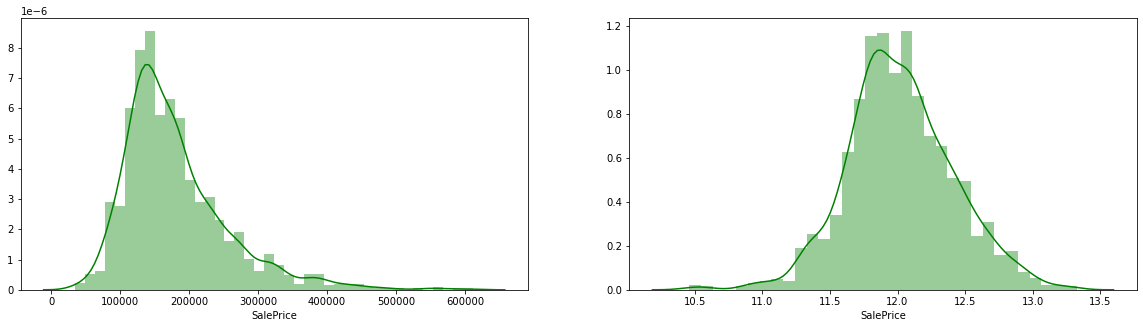

In [32]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.distplot(Train_Y_n,ax=ax[0],color='green')
sns.distplot(np.log1p(Train_Y_n),ax=ax[1],color='green')

In [33]:
y_train=np.log1p(Train_Y_n)

In [34]:
scaler=RobustScaler()
final_train_n=pd.DataFrame(scaler.fit_transform(Train_X_n),columns=Train_X_n.columns)
final_test_n=pd.DataFrame(scaler.fit_transform(test_n1[linear_features]),columns=Train_X_n.columns)

In [35]:
final_train_n.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Bsmt,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,0.054795,0.5,0.673913,0.263158,1.209877,-0.269618,1.173077,0.394104,0.589744,0.281690,0.000000,0.544118,0.0
1,0.465753,0.0,0.086957,-0.447368,0.000000,0.547284,0.000000,-0.301009,-0.102564,-0.072435,1.773810,-0.352941,0.0
2,0.136986,0.5,0.630435,0.236842,1.000000,-0.140845,1.189560,0.512025,0.538462,0.523139,0.000000,0.264706,0.0
3,-0.082192,0.5,-1.239130,-0.605263,0.000000,-0.470825,1.038462,0.404965,0.461538,0.659960,0.000000,0.161765,272.0
4,0.575342,1.0,0.608696,0.184211,2.160494,0.311871,1.446429,1.151280,0.512821,1.440644,1.142857,0.882353,0.0


In [36]:
train_c=train[[c for c in train.columns if train[c].dtypes=='O']].copy()
test_c=test[[c for c in test.columns if test[c].dtypes=='O']].copy()

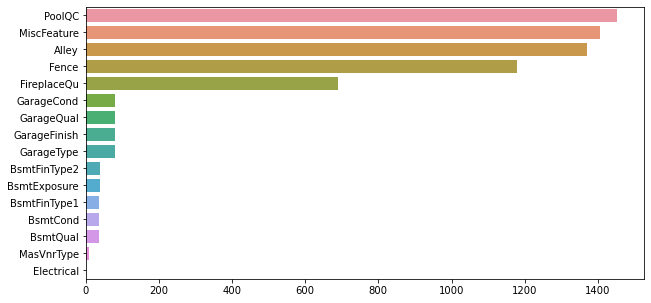

In [37]:
fig=plt.figure(figsize=(10,5))
train_null=train_c.isnull().sum()[train_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=train_null.index,x=train_null)

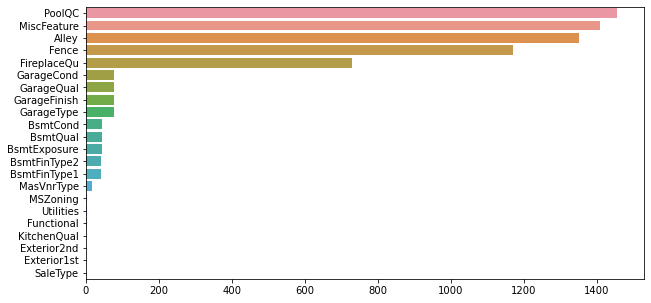

In [38]:
fig=plt.figure(figsize=(10,5))
test_null=test_c.isnull().sum()[test_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=test_null.index,x=test_null)

In [39]:
train_c.dropna(thresh=len(train_c)*0.9,axis=1,inplace=True)

In [40]:
test_c.dropna(thresh=len(test_c)*0.9,axis=1,inplace=True)

In [41]:
train_c['Electrical']=train_c['Electrical'].fillna(method='ffill')
test_c['SaleType']=test_c['SaleType'].fillna(method='ffill')
test_c['KitchenQual']=test_c['KitchenQual'].fillna(method='ffill')
test_c['Exterior1st']=test_c['Exterior1st'].fillna(method='ffill')
test_c['Exterior2nd']=test_c['Exterior2nd'].fillna(method='ffill')
test_c['Functional']=test_c['Functional'].fillna(method='ffill')
test_c['Utilities']=test_c['Utilities'].fillna(method='ffill')
test_c['MSZoning']=test_c['MSZoning'].fillna(method='ffill')

In [42]:
for col in train_c.columns:
    train_c[col] = train_c[col].fillna("None")
for col in test_c.columns:
    test_c[col] = test_c[col].fillna("None")

In [43]:
train_c=train_c.drop(index).reset_index(drop=True)
train_c.shape

(1451, 38)

In [44]:
num_train=train_n1[['OverallCond','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','KitchenAbvGr',
'BedroomAbvGr','Fireplaces','MoSold','YrSold']]
num_test=test_n1[['OverallCond','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','KitchenAbvGr',
'BedroomAbvGr','Fireplaces','MoSold','YrSold']]
print(num_train.shape)
print(num_test.shape)
numerical_categorical_feature=c = pd.concat((num_train,num_test),sort=False)
print(numerical_categorical_feature.shape)
numerical_categorical_feature=numerical_categorical_feature.astype('O')

(1451, 10)
(1459, 10)
(2910, 10)


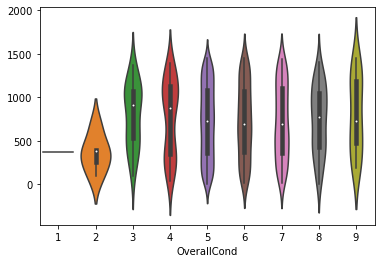

In [47]:
sns.violinplot(x=num_train['OverallCond'],y=num_train['OverallCond'].index)

In [48]:
numerical_categorical_feature=pd.get_dummies(numerical_categorical_feature)
num_train_dummy=numerical_categorical_feature[:1451]
num_test_dummy=numerical_categorical_feature[1451:].reset_index(drop=True)
print(num_train_dummy.shape)
print(num_test_dummy.shape)

(1451, 58)
(1459, 58)


In [49]:
c = pd.concat((train_c, test_c), sort=False).reset_index(drop=True)

In [50]:
c1=pd.get_dummies(c)

In [51]:
final_train_c=c1.iloc[:train_c.shape[0]]
final_train_c.shape

(1451, 242)

In [52]:
final_test_c=c1.iloc[train_c.shape[0]:]
final_test_c=final_test_c.reset_index(drop=True)
final_test_c.shape

(1459, 242)

In [53]:
final_train_c=final_train_c.merge(num_train_dummy,left_index=True,right_index=True)
final_test_c=final_test_c.merge(num_test_dummy,left_index=True,right_index=True)

In [54]:
train_c_labeled=pd.DataFrame()
test_c_labeled=pd.DataFrame()

for col in train_c.columns:
    le = preprocessing.LabelEncoder()
    train_c_labeled[col]=le.fit_transform(train_c[col])
    test_c_labeled[col]=le.fit_transform(test_c[col])

In [55]:
x_train=final_train_n.merge(final_train_c,left_index=True,right_index=True).reset_index(drop=True)
x_test=final_test_n.merge(final_test_c,left_index=True,right_index=True).reset_index(drop=True)

In [56]:
x_train_xgb=final_train_n.merge(train_c_labeled,left_index=True,right_index=True).reset_index(drop=True)
x_test_xgb=final_test_n.merge(test_c_labeled,left_index=True,right_index=True).reset_index(drop=True)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train,test_size = .3, random_state=0)

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
params = {"max_depth":[15,20,25], "n_estimators":[27,30,33]}
rf_reg = GridSearchCV(rf, params, cv = 10, n_jobs =10)
rf_reg.fit(X_train, Y_train)
print(rf_reg.best_estimator_)
best_estimator=rf_reg.best_estimator_
y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(Y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_pred_test)))) 

RandomForestRegressor(max_depth=15, n_estimators=27)
Root Mean Square Error train = 0.05629256747959031
Root Mean Square Error test = 0.15169392059794515


In [63]:
rf.fit(x_train,y_train)
y_test = rf.predict(x_test)

In [65]:
final_y_test = np.expm1(y_test)

In [66]:
final_y_test

array([124602.16003625, 153419.7822074 , 172283.25438149, ...,
       148469.06434306, 109805.61887579, 238305.48310559])

In [68]:
sample=pd.read_csv('sample_submission.csv')
submission=pd.DataFrame({"Id":sample['Id'],
                         "SalePrice":final_y_test})
submission.to_csv('submission.csv',index=False)

In [69]:
submission.head()

,Id,SalePrice
0,1461,124602.160036
1,1462,153419.782207
2,1463,172283.254381
3,1464,182777.487528
4,1465,204314.572367


In [72]:
from pdpbox import pdp
from plotnine import *

[autoreload of pandas.compat failed: Traceback (most recent call last):
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/pandas/compat/__init__.py", line 15, in <module>
    from pandas._typing 

[autoreload of pandas.core.arrays.categorical failed: Traceback (most recent call last):
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py", line 18, in <module>

[autoreload of pandas.core.indexes.extension failed: Traceback (most recent call last):
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", li

[autoreload of pandas.core.generic failed: Traceback (most recent call last):
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py", line 34, in <module>
    from pandas._libs

[autoreload of pandas.core.reshape.melt failed: Traceback (most recent call last):
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/melt.py", line 17, in <module>
    from pa

[autoreload of pandas._testing failed: Traceback (most recent call last):
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/mehmetuzel/opt/anaconda3/lib/python3.8/site-packages/pandas/_testing.py", line 2906, in <module>
    cython_table = pd.core.

In [75]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [76]:
set_rf_samples(50000)

In [78]:
def plot_feature_importance(fi): 
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)

In [80]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'columns':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)

In [81]:
plot_feature_importance(rf_feat_importance(rf, x_train)[:10]);

AttributeError: 'Index' object has no attribute '_ndarray_values'

Partial Dependence'i çalıştıramadım bir türlü